In [1]:
%matplotlib inline

import intake
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import util
import siutils as si

/srv/conda/envs/notebook/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['stac-catalog', 'stac-collection', 'stac-item'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


In [79]:
import importlib
importlib.reload(si)

<module 'siutils' from '/home/jovyan/cmip6-seaice-temp-sensitivity/notebooks/siutils.py'>

#### Get full catalogue of CMIP6 data on glade or cloud

In [3]:
if util.is_ncar_host():
    col = intake.open_esm_datastore("../catalogs/glade-cmip6.json")
else:
    col = intake.open_esm_datastore("../catalogs/pangeo-cmip6.json")

### Find file names for various specifications

In [4]:
cat_siconc = col.search(experiment_id=['historical'],table_id='SImon', 
                        variable_id='siconc', grid_label='gn')

cat_cellarea = col.search(experiment_id=['historical'],table_id='Ofx', 
                          variable_id='areacello', grid_label='gn')

cat_tas = col.search(experiment_id=['historical'],table_id='Amon', 
                          variable_id='tas', grid_label='gn')

#### Find where models contain all necessary variables

In [5]:
uni_dict = col.unique(['source_id', 'experiment_id', 'table_id'])

models_intersect = set(uni_dict['source_id']['values']) # all the models
table_id = ['SImon','Ofx','Amon']
var_list = ['siconc','areacello','tas']
exp = 'historical'

models_intersect = si.find_overlap_models(var_list,exp,table_id,models_intersect,col)

### Load data: 

In [7]:
ardset_dict = cat_cellarea.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': True}, 
                                           cdf_kwargs={'chunks': {}, 'decode_times': True})

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 13 group(s)


In [8]:
sidset_dict = cat_siconc.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': True}, 
                                         cdf_kwargs={'chunks': {}, 'decode_times': True})

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 18 group(s)


In [9]:
tasdset_dict = cat_tas.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': True}, 
                                         cdf_kwargs={'chunks': {}, 'decode_times': True})

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 18 group(s)


In [10]:
# Creates dictionary relating model names to file names
amodel_name_dict = {ardset_dict[x].attrs['source_id']: x for x in ardset_dict}
smodel_name_dict = {sidset_dict[x].attrs['source_id']: x for x in sidset_dict}
tmodel_name_dict = {tasdset_dict[x].attrs['source_id']: x for x in tasdset_dict}

In [11]:
# Adding areacello as variable in other datasets and making key of dataset model name
si_dict_temp = {}
tas_dict = {}

for key, item in sidset_dict.items():
    model = item.attrs['source_id']
    if model in models_intersect: 
        si_dict_temp[model] = item
        si_dict_temp[model]['areacello'] = ardset_dict[amodel_name_dict[model]]['areacello']
        tas_dict[model] = tasdset_dict[tmodel_name_dict[model]]

### Set single model to look at

In [157]:
print(models_intersect)
m=models_intersect[5] #Will loop over all of these later
print(m)

['CanESM5', 'CESM2', 'MIROC-ES2L', 'MIROC6', 'NorCPM1', 'SAM0-UNICON']
SAM0-UNICON


In [158]:
# Rename dimensions so they're all the same: 
si_dict = {}
for m in models_intersect:
    si_dict[m] = si.rename_dimensions(si_dict_temp[m],si_dict)

#### Calculate extent: 

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


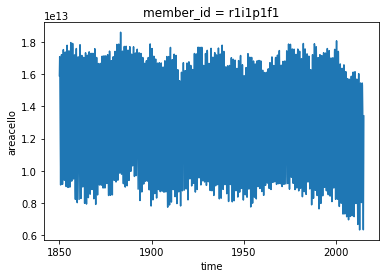

In [159]:
ts_Arctic_extent = si.Arctic_SIextent(si_dict[m]['siconc'], si_dict[m]['areacello'], 0)
ts_Arctic_extent.plot()

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


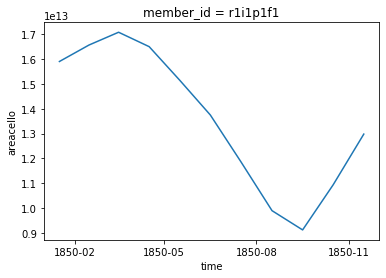

In [160]:
#Plot a single year
ts_Arctic_extent[0:11].plot()

### Get extent climatology

In [161]:
month_lab = ['Jan','Feb','Mar','Apr','May','June','Jul','Aug','Sept','Oct','Nov','Dec']

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


Text(0, 0.5, 'Arctic sea ice extent (m$^{2}$)')

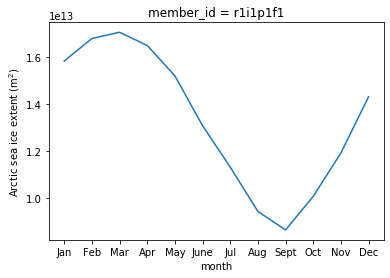

In [162]:
#Plot climatology
si_mon_mn = ts_Arctic_extent.groupby('time.month').mean('time')
si_mon_mn.plot()
plt.xticks(np.arange(1,13,1), month_lab)
plt.ylabel('Arctic sea ice extent (m$^{2}$)')

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


Text(0, 0.5, 'Arctic sea ice extent std (m$^{2}$)')

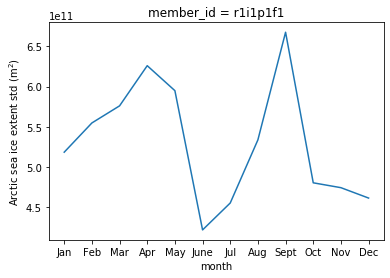

In [163]:
#Plot std in each month (does this look right?)
si_mon_std = ts_Arctic_extent.groupby('time.month').std()
si_mon_std.plot()
plt.xticks(np.arange(1,13,1), month_lab)
plt.ylabel('Arctic sea ice extent std (m$^{2}$)')

### Calculate average Arctic surface temperature

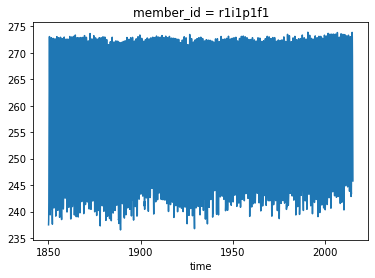

In [164]:
ts_tas_ArcticAve = si.arctic_mean(tas_dict[m],tas_dict[m]['tas'],70)
ts_tas_ArcticAve[0,:].plot()

### Get temperature climatology

Text(0, 0.5, 'Arctic average T (K)')

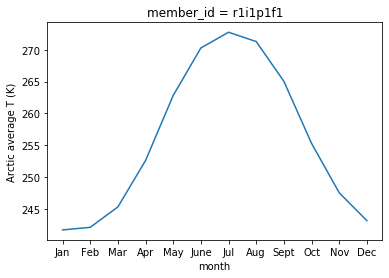

In [165]:
#Plot climatology
ts_mon_mn = ts_tas_ArcticAve.groupby('time.month').mean('time')
ts_mon_mn.plot()
plt.xticks(np.arange(1,13,1), month_lab)
plt.ylabel('Arctic average T (K)')

Text(0, 0.5, 'Arctic averate T std (K)')

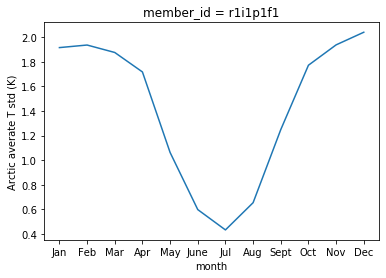

In [166]:
#Plot std in each month (does this look right?)
ts_mon_std = ts_tas_ArcticAve.groupby('time.month').std()
ts_mon_std.plot()
plt.xticks(np.arange(1,13,1), month_lab)
plt.ylabel('Arctic averate T std (K)')

### Problems

In [ ]:
#1.
    #m=1 (CESM2)
    #Plotting requires coordinates to be numeric or dates of type np.datetime64, datetime.datetime,
    #cftime.datetime or pd.Interval.
    
    